<a href="https://colab.research.google.com/github/princexoleo/u_net_pattern_lab/blob/master/u_net_with_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Semantic Segmentation

In [1]:
from fastai import *
from fastai.vision import *

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl=path/'labels'
path_img= path/'images'

##Data

In [4]:
# Images files name from the images folder
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_008730.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01380.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_02400.png')]

In [5]:
# Labels names from the Labels folder
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03030_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08149_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04440_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02820_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06000_P.png')]

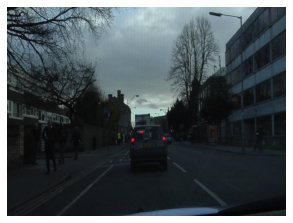

In [6]:
# Show a Images
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
# get equlibent files names according to labels name
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

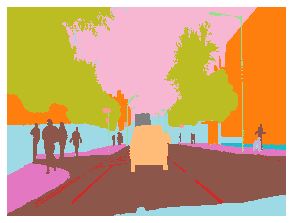

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
# size of the images 
src_size = np.array(mask.shape[1:])
print(src_size)
print(mask.data)

[720 960]
tensor([[[26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])


In [11]:
# class/codes names
codes = np.loadtxt(path/'codes.txt', dtype=str)
print(codes)

['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


##Datasets and Databunch

In [0]:
size = src_size//2
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes)
      )

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

#tfm_y means transform y 


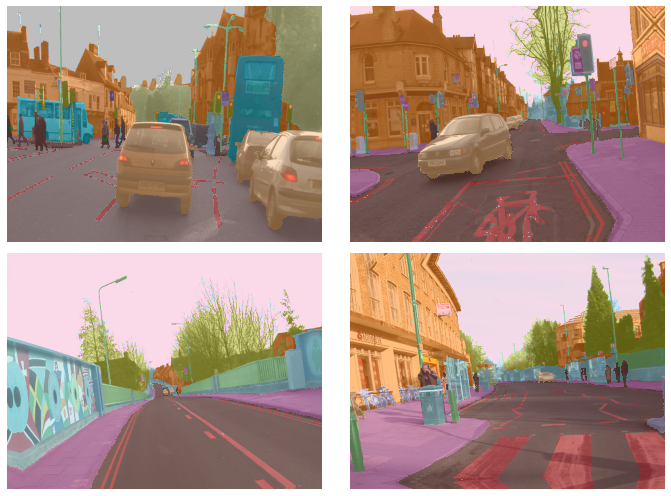

In [21]:
data.show_batch(2, figsize=(10,7))

##Model

In [0]:
# to avoid some Void  name label pixel 
name2id = {v:v for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
# metrics
metrics = acc_camvid
wd = 1e-2

In [0]:
# Used Uner model with renet34 architechture
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


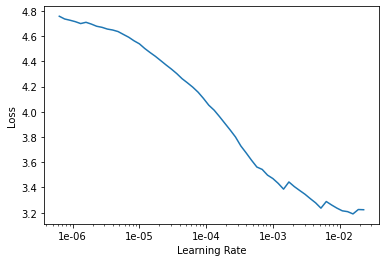

In [34]:
# LR finder
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [36]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.331188,0.957542,0.773220,00:54
1,0.879426,0.728882,0.804221,00:51
2,0.718747,0.575055,0.837448,00:50
3,0.654395,0.518763,0.848981,00:51
4,0.611272,0.607032,0.829919,00:50
5,0.618402,0.486327,0.862197,00:50
6,0.573512,0.453402,0.868430,00:51
7,0.539614,0.465152,0.866211,00:51
8,0.519538,0.417993,0.876642,00:50
9,0.449395,0.346210,0.885578,00:51


In [0]:
learn.save('Stage-1')

In [0]:
learn.load('Stage-1');

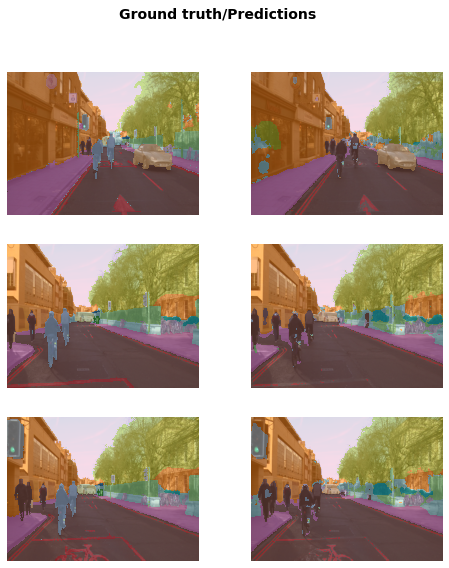

In [41]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)

In [43]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.377847,0.327667,0.891488,00:53
1,0.371832,0.319868,0.898428,00:52
2,0.357770,0.324345,0.896253,00:52
3,0.350260,0.304993,0.904771,00:52
4,0.336820,0.291160,0.914043,00:52
5,0.331512,0.297778,0.912346,00:52
6,0.329777,0.306268,0.906952,00:52
7,0.317410,0.270941,0.921676,00:52
8,0.310094,0.291702,0.910466,00:52
9,0.296075,0.265560,0.920899,00:52


In [0]:
learn.save('stage-2');

#More Improvement

In [45]:
learn.destroy()
size = src_size
bs = 3


this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
# load stage 2
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


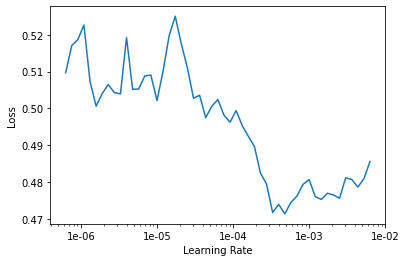

In [49]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [50]:
learn.fit_one_cycle(10, slice(1e-4,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.379865,0.332291,0.901908,03:36
1,0.343731,0.319884,0.906516,03:33
2,0.338987,0.300038,0.907117,03:33
3,0.319852,0.318122,0.906822,03:33
4,0.338356,0.298697,0.909411,03:33
5,0.333327,0.298463,0.911435,03:33
6,0.328012,0.302759,0.911183,03:33
7,0.328761,0.299800,0.915802,03:33
8,0.283570,0.271544,0.920806,03:33
9,0.229689,0.260849,0.924171,03:33


In [0]:
# sabe the model
learn.save('stage-1-big')

In [0]:
# again load the model
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [55]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.225487,0.257461,0.925787,03:40
1,0.225561,0.263643,0.924515,03:39
2,0.228370,0.260772,0.924211,03:40
3,0.224679,0.266464,0.925175,03:39
4,0.205838,0.257984,0.927057,03:39
5,0.198402,0.256571,0.928549,03:39
6,0.187581,0.269591,0.923461,03:40
7,0.190017,0.252107,0.927732,03:39
8,0.184214,0.254694,0.928807,03:40
9,0.184647,0.255929,0.928901,03:40


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

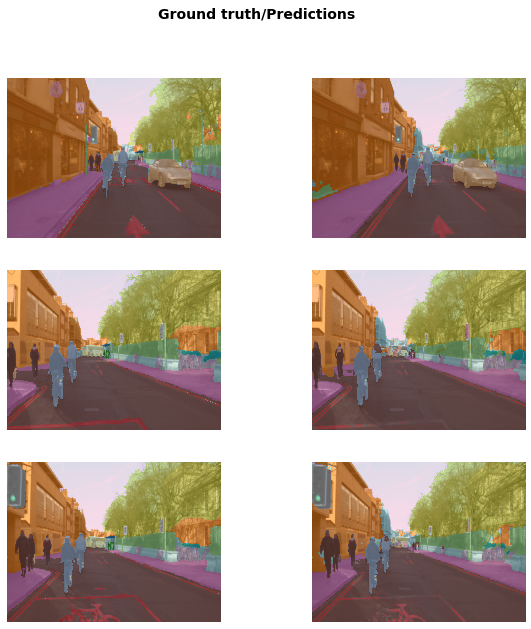

In [59]:
learn.show_results(rows=3, figsize=(10,10))